# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processed from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [1]:
# Import packages
import os

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd

import rioxarray as rioxr

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [2]:
# Import NIR TIF file
root = os.path.join('data','NAIP_SB')
nir = rioxr.open_rasterio(os.path.join(root, 'NAIP_SB_nir.tif'))
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [3]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

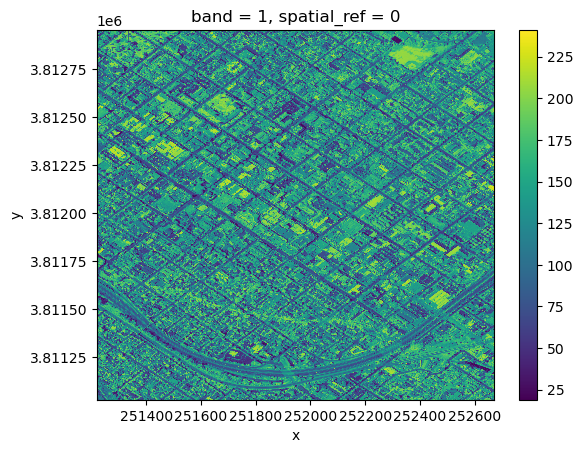

In [4]:
nir.plot()

## Drop a dimension 

Our raster has an unnecessary dimension: band 

In [5]:
print("Size of dimensions: ", dict(nir.sizes))

Size of dimensions:  {'band': 1, 'y': 3208, 'x': 2419}


We can squeeze the dimension of length 1 by: 

1. Using the squeeze() method. no parameters = gets rid of all dimensions length one

2. Removing associated coordinates for this dimension using drop

In [6]:
# Orginal dimensions and coordinates 

print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [7]:
# Remove length 1 dimension (band)
nir = nir.squeeze()
print(nir.dims, '\n', nir.coords)

('y', 'x') 
 Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [8]:
# Remove coordinates associatedd to band 

nir = nir.drop_vars('band')
print(nir.dims, '\n', nir.coords)


('y', 'x') 
 Coordinates:
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


## rio accessor 

Use the .rio accessor for an xarray.DataArray to access its raster properties 

In [9]:
# Examine the raster attributes using the rio accesor 

print('Number of bands: ', nir.rio.count)
print('Height :', nir.rio.height)
print('Width :', nir.rio.width, '\n')

print('Spatial bounding box :', nir.rio.bounds())
print('CRS:', nir.rio.crs)


Number of bands:  1
Height : 3208
Width : 2419 

Spatial bounding box : (251218.8, 3811027.2, 252670.19999999998, 3812952.0)
CRS: EPSG:26911


## Multi band raster 

In [10]:
# Import RGB raster 

# Import RGB raster
fp = os.path.join('data','NAIP_SB', 'NAIP_SB_rgb.tif')
rgb = rioxr.open_rasterio(fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
print('CRS: ', rgb.rio.crs)

CRS:  EPSG:26911


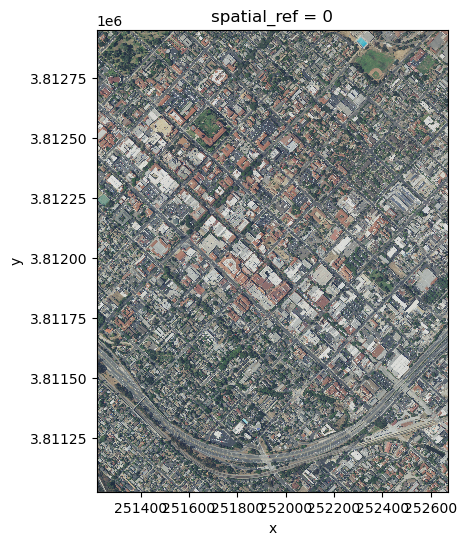

In [12]:
# PLot three bands as RGB image 

rgb_aspect_ratio = rgb.rio.width / rgb.rio.height  # Raster's aspect ratio 

rgb.plot.imshow(size = 6, 
                aspect = rgb_aspect_ratio)

## Clip raster 

Our area of interest  is smaller region around NCEAS 

<Axes: >

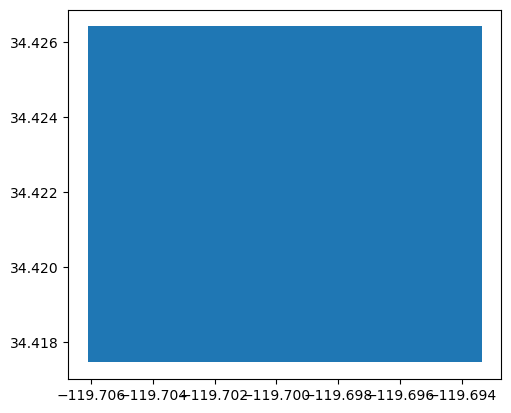

In [13]:
# Import AOI around NCEAS building 

aoi = gpd.read_file(os.path.join('data', 'SB_aoi.geojson'))

aoi.plot()

In [14]:
# Examine CRSs 

print('aoi CRS: ', aoi.crs)
print('nir CRS:', nir.rio.crs)
print('rgb crs:', rgb.rio.crs)

aoi CRS:  EPSG:4326
nir CRS: EPSG:26911
rgb crs: EPSG:26911


In [15]:
# Reproject AOI to RGB CRS 

aoi = aoi.to_crs(rgb.rio.crs)
assert aoi.crs == rgb.rio.crs

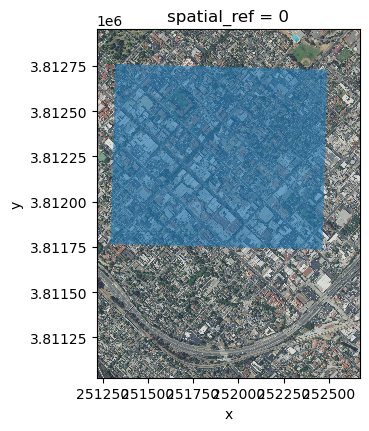

In [16]:
fig, ax = plt.subplots(figsize = (6, 6*rgb_aspect_ratio)) # Directly show size and ratio 

rgb.plot.imshow(ax = ax) 
aoi.plot(ax = ax, alpha = 0.6)
plt.show()

In [17]:
# Clip rasters to AOI 
# Total bounds gets xmin/max and ymin/max 

rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = rgb.rio.clip_box(*aoi.total_bounds)

Original shape: (3208, 2419)
Clipped shape: (3, 1710, 1995)


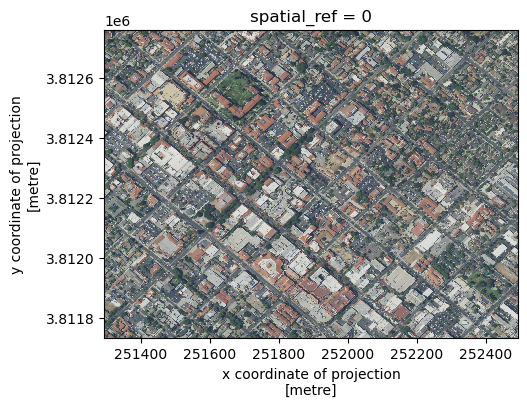

In [18]:
# Examine clipped data 

print('Original shape:', nir.shape)
print('Clipped shape:', nir_small.shape)

# Plot with correct sizes 

ratio = rgb_small.rio.width / rgb_small.rio.height 
rgb_small.plot.imshow(size = 4)

## Raster math 

Comput the Normalized Difference Vegetation Index (NDVI) over our AOI

NDVI index to check if areas have live green vegetation or not.

Values range from -1 to 1.

NDVI <0 = water surfaces, man made structure, rock, snow

01 < NDVI <0.2 bare soil 

0.3 < NDVI < sparse vegetation 

0.5 < NDVI - dense vegetation canopy 

NDVI calculated using NIR and red bands 

$$ NDVI = \frac{NIR - Red }{NIR + Red} $$

In [19]:
# Select red band by dimension by name and coordinate by label 

red = rgb_small.sel(band =1)
red

<xarray.DataArray (y: 1710, x: 1995)> Size: 3MB
[3411450 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [20]:
ndvi = (nir - red)/(nir + red)

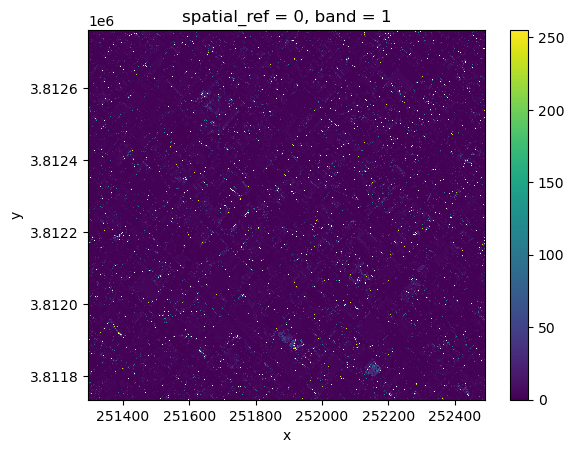

In [21]:
ndvi.plot()

## Data type issues 


The uint8 (8-bit unsigned integer) is a very small data type that only holds integers from 0 to 255. In particular, calculations dont return what we are used to when working with integers. (Theyre done mudle 2555)

In [22]:
# Calculation with uint8 numbers 

np.uint8(150) + np.int8(150)

/var/folders/8d/5sd6q3991mz6_07cyfcp2y680000gn/T/ipykernel_62104/4286490539.py:3: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 150 to int8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  np.uint8(150) + np.int8(150)


44

## Update data type of our rasters into int16 which is big enough to hold numbers from the NDVI calculation 

In [23]:
# Update data type to int16 to perform NDVI 

red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

print('RED - original dtyep:', red.dtype, '..... converted type: ', red16.dtype)
print('NIR - original dtyep:', nir.dtype, '..... converted type: ', nir16.dtype)

RED - original dtyep: uint8 ..... converted type:  int16
NIR - original dtyep: uint8 ..... converted type:  int16


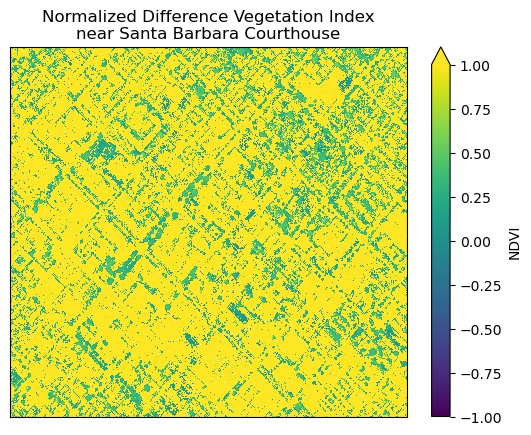

In [24]:

# Plot
fig, ax = plt.subplots()  # Adjust figure size
ndvi.plot(
    ax=ax,  # Colormap for NDVI
    vmin=-1,  # Minimum value
    vmax=1,   # Maximum value
    cbar_kwargs={"label": "NDVI"}  # Label for color bar
)
ax.set_title("Normalized Difference Vegetation Index\nnear Santa Barbara Courthouse")  # Add title

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

plt.show()